# Finding the path of dataset 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):  
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


# Imorting Libraries

In [2]:
import os
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils.np_utils import to_categorical
from joblib import dump, load

# Reading the dataset

In [3]:
text = []
clas = []
df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
text = df['tweet'].tolist()
clas = df['class'].tolist()

# creating a new dataframe for easy text processing

In [4]:
df = pd.DataFrame({'tweet': text, 'class': clas})

# Finding if there is any missing data

In [5]:
print(df.isnull().sum())

tweet    0
class    0
dtype: int64


# Converting the data into lower case.

In [6]:
df['tweet'] = df['tweet'].apply(lambda x:x.lower())

# removing punctuations

In [7]:
punctuation_signs = list("?:!.,;")
df['tweet'] = df['tweet']

for punct_sign in punctuation_signs:   
    df['tweet'] = df['tweet'].str.replace(punct_sign, '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


# Removing '\n' and '\t', extra spaces, quoting text, and progressive pronouns.

In [8]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")

# removing stop-words

In [9]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


# Using Bag of Words approach for final data Preparation.¶

In [10]:
cv = CountVectorizer(max_features = 75)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

# Splitting the Data using Stratified split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Using Random Forest Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.8406186953597848


['rf.joblib']

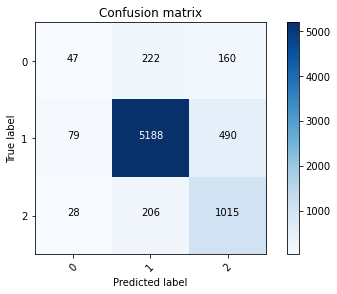

In [13]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'rf.joblib') 

# Using Decision tree as the Model and printing evaluating it using confusion matrix

accuracy is:  0.8227303295225286


['decision.joblib']

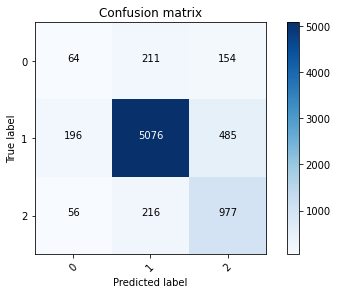

In [14]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'decision.joblib') 

# Using AdaBoost Classifier as the Model and printing evaluating it using confusion matrix

accuracy is:  0.8468056489576328


['ada.joblib']

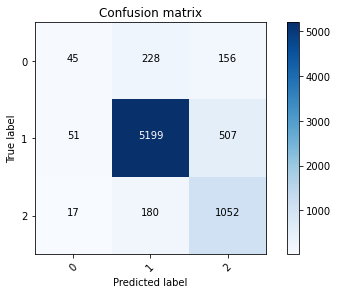

In [15]:
clf = AdaBoostClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(3))
dump(clf, 'ada.joblib') 

# Converting the labels into categorical format

In [16]:
y_train=to_categorical(y_train, num_classes = 3, dtype='float32')
y_test=to_categorical(y_test, num_classes = 3, dtype='float32')

# Creating and Training an LSTM Model

In [17]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 64

history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/25
272/272 [==============================] - 75s 263ms/step - loss: 0.4267 - accuracy: 0.7700 - val_loss: 0.4028 - val_accuracy: 0.7743
Epoch 2/25
272/272 [==============================] - 70s 257ms/step - loss: 0.4022 - accuracy: 0.7743 - val_loss: 0.4015 - val_accuracy: 0.7743
Epoch 3/25
272/272 [==============================] - 71s 259ms/step - loss: 0.4019 - accuracy: 0.7743 - val_loss: 0.4016 - val_accuracy: 0.7743
Epoch 4/25
272/272 [==============================] - 71s 259ms/step - loss: 0.4013 - accuracy: 0.7743 - val_loss: 0.4010 - val_accuracy: 0.7743
Epoch 5/25
272/272 [==============================] - 71s 259ms/step - loss: 0.4013 - accuracy: 0.7743 - val_loss: 0.4006 - val_accuracy: 0.7743
Epoch 6/25
272/272 [==============================] - 70s 259ms/step - loss: 0.4008 - accuracy: 0.7743 - val_loss: 0.4001 - val_accuracy: 0.7743
Epoch 7/25
272/272 [==============================] - 70s 259ms/step - loss: 0.4001 - accuracy: 0.7743 - val_loss: 0.3987 - val_ac

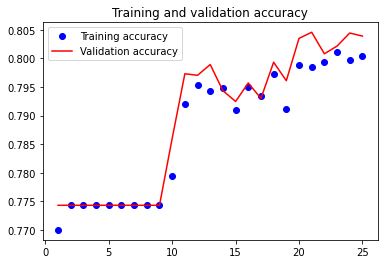

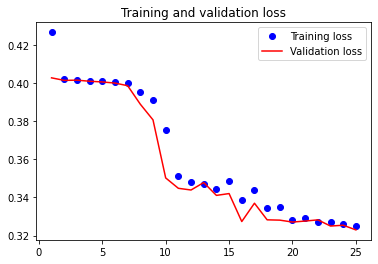

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Saving the LSTM Model

In [19]:
model.save('lstm.h5')